# Feature Engineering


## 1. Import packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

---
## 2. Load data

In [2]:
df = pd.read_csv('clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [3]:
df.head(3)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.000131,4.100838e-05,0.000908,2.086294,99.530517,44.235794,2.086425,9.953056e+01,44.236702,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000003,1.217891e-03,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000004,9.450150e-08,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000,0


---

## 3. Feature engineering

### Difference between off-peak prices in December and preceding January


In [4]:
price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


In [5]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'dec_1', 'price_off_peak_fix': 'dec_2'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['dec_1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_2'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001


In [6]:
# Lets merge this df to start dataFrame

df_merged = pd.merge(df, diff, on='id')
df_merged.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916


## Prices changes across given period

In [7]:
# Aggregate average prices per period

mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [8]:
# Calculate the mean difference 
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['peak_mid_peak_var_mean_diff'] = mean_prices['price_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_mid_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_mid_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']
mean_prices['peak_mid_peak_fix_mean_diff'] = mean_prices['price_peak_fix'] - mean_prices['price_mid_peak_fix']
mean_prices['off_peak_mid_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_mid_peak_fix']

In [9]:
# Add new columns in df and merge on id

add_columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'peak_mid_peak_var_mean_diff', 
    'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 
    'peak_mid_peak_fix_mean_diff', 
    'off_peak_mid_peak_fix_mean_diff'
]
new_df = pd.merge(df_merged, mean_prices[add_columns], on='id')
new_df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893


In [10]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()


In [11]:
# Calculate the mean difference between consecutive periods
mean_prices_by_month['off_peak_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_peak_var']
mean_prices_by_month['peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_mid_peak_var_mean_diff'] = mean_prices_by_month['price_off_peak_var'] - mean_prices_by_month['price_mid_peak_var']
mean_prices_by_month['off_peak_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_peak_fix']
mean_prices_by_month['peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']
mean_prices_by_month['off_peak_mid_peak_fix_mean_diff'] = mean_prices_by_month['price_off_peak_fix'] - mean_prices_by_month['price_mid_peak_fix']

In [12]:
# Calculate the maximum monthly difference across time periods
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'off_peak_peak_var_mean_diff': 'max',
    'peak_mid_peak_var_mean_diff': 'max',
    'off_peak_mid_peak_var_mean_diff': 'max',
    'off_peak_peak_fix_mean_diff': 'max',
    'peak_mid_peak_fix_mean_diff': 'max',
    'off_peak_mid_peak_fix_mean_diff': 'max'
}).reset_index().rename(
    columns={
        'off_peak_peak_var_mean_diff': 'off_peak_peak_var_max_monthly_diff',
        'peak_mid_peak_var_mean_diff': 'peak_mid_peak_var_max_monthly_diff',
        'off_peak_mid_peak_var_mean_diff': 'off_peak_mid_peak_var_max_monthly_diff',
        'off_peak_peak_fix_mean_diff': 'off_peak_peak_fix_max_monthly_diff',
        'peak_mid_peak_fix_mean_diff': 'peak_mid_peak_fix_max_monthly_diff',
        'off_peak_mid_peak_fix_mean_diff': 'off_peak_mid_peak_fix_max_monthly_diff'
    }
)

In [13]:
add_columns_2 = [
    'id',
    'off_peak_peak_var_max_monthly_diff',
    'peak_mid_peak_var_max_monthly_diff',
    'off_peak_mid_peak_var_max_monthly_diff',
    'off_peak_peak_fix_max_monthly_diff',
    'peak_mid_peak_fix_max_monthly_diff',
    'off_peak_mid_peak_fix_max_monthly_diff'
]

agg_df = pd.merge(new_df, max_diff_across_periods_months[add_columns_2], on='id')
agg_df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733


In [14]:
agg_df.describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff
count,1.460600e+04,1.460600e+04,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,...,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.592203e+05,2.809238e+04,16090.269752,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056,...,0.114052,33.468016,3.363194,36.831210,0.094262,0.029431,0.119895,34.279812,3.414798,37.446785
std,5.734653e+05,1.629731e+05,64364.196422,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988,...,0.052634,13.823118,4.816155,10.228129,0.061457,0.033006,0.052129,13.857335,4.864716,10.267419
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674750e+03,0.000000e+00,0.000000,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701,...,0.050702,16.275263,0.000000,24.412893,0.022581,0.000000,0.054659,16.291555,0.000000,24.437330
50%,1.411550e+04,0.000000e+00,792.500000,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378,...,0.147409,44.266930,0.000000,44.281745,0.084587,0.031859,0.149555,44.266931,0.000000,44.444710
75%,4.076375e+04,0.000000e+00,3383.000000,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378,...,0.150156,44.365079,8.121339,44.370635,0.151367,0.033743,0.152445,44.444710,8.145775,44.444710
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378,...,0.278098,59.286190,28.122958,59.286190,0.280700,0.229788,0.280700,59.444710,28.122958,59.444710


The data has a wide range for each feature, especially for cons_12m and cons_last_month, indicating possible outliers. The distribution is highly skewed as seen from the difference between the percentiles and the means. The medians are much lower than the means.


### Transform dates into months to have more understandable data

In [15]:
from datetime import datetime


In [16]:
# Identify reference date

reference_date = datetime(2016,1,1)

In [17]:
# Create function to define months

def convert_months(reference_date, agg_df, column):
    
    time_delta = reference_date - agg_df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

In [18]:
# Create new columns

agg_df['months_activ'] = convert_months(reference_date, agg_df, 'date_activ')
agg_df['months_to_end'] = -convert_months(reference_date, agg_df, 'date_end') # Date_end is later than reference date
agg_df['months_modif_prod'] = convert_months(reference_date, agg_df, 'date_modif_prod')
agg_df['months_renewal'] = convert_months(reference_date, agg_df, 'date_renewal')
agg_df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693,30,5,2,6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471,76,7,76,4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471,68,3,68,8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471,69,2,69,9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733,71,2,71,9


In [19]:
# Drop columns with dates

agg_df = agg_df.drop([
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
], axis = 1)
agg_df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693,30,5,2,6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471,76,7,76,4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471,68,3,68,8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,...,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471,69,2,69,9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,...,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733,71,2,71,9


In [20]:
# Display all columns to better understand DF

pd.options.display.max_columns = None 
display(agg_df)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,var_year_price_off_peak_var,var_year_price_peak_var,var_year_price_mid_peak_var,var_year_price_off_peak_fix,var_year_price_peak_fix,var_year_price_mid_peak_fix,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,0.000061,2.627605e-05,4.402763e-04,1.102785e+00,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.266930,30,5,2,6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0.000005,6.089453e-04,0.000000e+00,6.464779e-03,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.444710,76,7,76,4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0.000006,2.558511e-07,0.000000e+00,7.661891e-03,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.444710,68,3,68,8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0.000005,0.000000e+00,0.000000e+00,6.464721e-03,0.000000,0.000000,0.006470,0.000000e+00,0.000000,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.444710,69,2,69,9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0.000015,3.552481e-06,2.522046e-06,5.428942e-03,0.001954,0.000869,0.005444,1.957971e-03,0.000871,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.437330,71,2,71,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,

In [21]:
# Get dummies to has_gas column

has_gas_dummies = pd.get_dummies(agg_df['has_gas'])
has_gas_dummies.head()

,f,t
0,0,1
1,1,0
2,1,0
3,1,0
4,1,0


In [22]:
agg_df = pd.concat([agg_df, has_gas_dummies], axis = 1)
agg_df.head(10)

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,var_year_price_off_peak_var,var_year_price_peak_var,var_year_price_mid_peak_var,var_year_price_off_peak_fix,var_year_price_peak_fix,var_year_price_mid_peak_fix,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal,f,t
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,0.000061,2.627605e-05,0.000440,1.102785e+00,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.266930,30,5,2,6,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0.000005,6.089453e-04,0.000000,6.464779e-03,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.444710,76,7,76,4,1,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0.000006,2.558511e-07,0.000000,7.661891e-03,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.444710,68,3,68,8,1,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0.000005,0.000000e+00,0.000000,6.464721e-03,0.000000,0.000000,0.006470,0.000000e+00,0.000000,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.444710,69,2,69,9,1,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0.000015,3.552481e-06,0.000003,5.428942e-03,0.001954,0.000869,0.005444,1.957971e-03,0.000871,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.437330,71,2,71,9,1,0
5,1aa498825382410b098937d65c4ec26d,usilxuppasemubllopkaafesmlibmsdf,8302,0,1998,796.94,1

### Channel sales transformation

During EDA we have found some channels which had only few occurrences, so lets do some transformations with this data and remove them.

In [23]:
# Rename channels for convinience
channel_renames = {
    'foosdfpfkusacimwkcsosbicdxkicaua': 'Channel 1',
    'MISSING': 'Channel 2',
    'lmkebamcaaclubfxadlmueccxoimlema': 'Channel 3',
    'usilxuppasemubllopkaafesmlibmsdf': 'Channel 4',
    'ewpakwlliwisiwduibdlfmalxowmwpci': 'Channel 5',
    'sddiedcslfslkckwlfkdpoeeailfpeds': 'Channel 6',
    'epumfxlbckeskwekxbiuasklxalciiuu': 'Channel 7',
    'fixdbufsefwooaasfcxdxadsiekoceaa': 'Channel 8'
}

agg_df.loc[:, 'channel_sales'] = agg_df['channel_sales'].replace(channel_renames)
agg_df

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,var_year_price_off_peak_var,var_year_price_peak_var,var_year_price_mid_peak_var,var_year_price_off_peak_fix,var_year_price_peak_fix,var_year_price_mid_peak_fix,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal,f,t
0,24011ae4ebbe3035111d65fa7c15bc57,Channel 1,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,0.000061,2.627605e-05,4.402763e-04,1.102785e+00,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.266930,30,5,2,6,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,Channel 2,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0.000005,6.089453e-04,0.000000e+00,6.464779e-03,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.444710,76,7,76,4,1,0
2,764c75f661154dac3a6c254cd082ea7d,Channel 1,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0.000006,2.558511e-07,0.000000e+00,7.661891e-03,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.444710,68,3,68,8,1,0
3,bba03439a292a1e166f80264c16191cb,Channel 3,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0.000005,0.000000e+00,0.000000e+00,6.464721e-03,0.000000,0.000000,0.006470,0.000000e+00,0.000000,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.444710,69,2,69,9,1,0
4,149d57cf92fc41cf94415803a877cb4b,Channel 2,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0.000015,3.552481e-06,2.522046e-06,5.428942e-03,0.001954,0.000869,0.005444,1.957971e-03,0.000871,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.437330,71,2,71,9,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [24]:
agg_df = agg_df[agg_df['channel_sales'].isin(['Channel 1', 'Channel 2', 'Channel 3', 'Channel 4', 'Channel 5'])]


In [25]:
#Get_dummies to the 'channel_sales' column
agg_df = pd.get_dummies(agg_df, columns=['channel_sales'], drop_first=False)

agg_df

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,var_year_price_off_peak_var,var_year_price_peak_var,var_year_price_mid_peak_var,var_year_price_off_peak_fix,var_year_price_peak_fix,var_year_price_mid_peak_fix,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal,f,t,channel_sales_Channel 1,channel_sales_Channel 2,channel_sales_Channel 3,channel_sales_Channel 4,channel_sales_Channel 5
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,0.000061,2.627605e-05,4.402763e-04,1.102785e+00,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.266930,30,5,2,6,0,1,1,0,0,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0.000005,6.089453e-04,0.000000e+00,6.464779e-03,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.444710,76,7,76,4,1,0,0,1,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0.000006,2.558511e-07,0.000000e+00,7.661891e-03,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.444710,68,3,68,8,1,0,1,0,0,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0.000005,0.000000e+00,0.000000e+00,6.464721e-03,0.000000,0.000000,0.006470,0.000000e+00,0.000000,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.444710,69,2,69,9,1,0,0,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0.000015,3.552481e-06,2.522046e-06,5.428942e-03,0.001954,0.000869,0.005444,1.957971e-03,0.000871,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.437330,71,2,71,9,1,0,0,1,0,0,0
...,...,...,...,...,...,...

### Origin up column

In [26]:
# Define how many categories are within this column

agg_df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7094
kamkkxfxxuwbdslkwifmmcsiusiuosws    4292
ldkssxwpmemidmecebumciepifcamkci    3137
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

In [27]:
# Due to low frequency we remove 3 categories 
# Rename them
# Get dummies

origin_up_renames = {
    'lxidpiddsbxsbosboudacockeimpuepw': 'Category 1',
    'kamkkxfxxuwbdslkwifmmcsiusiuosws': 'Category 2',
    'ldkssxwpmemidmecebumciepifcamkci': 'Category 3',
    'MISSING ': 'C4',
    'usapbepcfoloekilkwsdiboslwaxobdp': 'C5',
    'ewxeelcelemmiwuafmddpobolfuxioce': 'C6'
}

agg_df.loc[:, 'origin_up'] = agg_df['origin_up'].replace(origin_up_renames)

agg_df = agg_df[agg_df['origin_up'].isin(['Category 1', 'Category 2', 'Category 3'])]

agg_df = pd.get_dummies(agg_df, columns=['origin_up'], drop_first=False)

agg_df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,var_year_price_off_peak_var,var_year_price_peak_var,var_year_price_mid_peak_var,var_year_price_off_peak_fix,var_year_price_peak_fix,var_year_price_mid_peak_fix,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal,f,t,channel_sales_Channel 1,channel_sales_Channel 2,channel_sales_Channel 3,channel_sales_Channel 4,channel_sales_Channel 5,origin_up_Category 1,origin_up_Category 2,origin_up_Category 3
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,43.648,0.000061,2.627605e-05,0.000440,1.102785,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693,30,5,2,6,0,1,1,0,0,0,0,1,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,13.800,0.000005,6.089453e-04,0.000000,0.006465,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471,76,7,76,4,1,0,0,1,0,0,0,0,1,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,13.856,0.000006,2.558511e-07,0.000000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471,68,3,68,8,1,0,1,0,0,0,0,0,1,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,13.200,0.000005,0.000000e+00,0.000000,0.006465,0.000000,0.000000,0.006470,0.000000e+00,0.000000,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471,69,2,69,9,1,0,0,0,1,0,0,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,19.800,0.000015,3.552481e-06,0.000003,0.005429,0.001954,0.000869,0.005444,1.957971e-03,0.000871,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733,71,2,71,9,1,0,0,1,0,0,0,0,1,0


### Data normalization

As we determined the data is highly skewed, lets apply logarithmic transformation

In [28]:
# Start with margin values
# Identify the threshold for capping (95th percentile)

cap_threshold_gross = agg_df['margin_gross_pow_ele'].quantile(0.95)
cap_threshold_net = agg_df['margin_net_pow_ele'].quantile(0.95)
cap_threshold_net_margin = agg_df['net_margin'].quantile(0.95)


In [29]:
# Cap the outliers
agg_df['margin_gross_pow_ele_capped'] = np.where(agg_df['margin_gross_pow_ele'] > cap_threshold_gross, cap_threshold_gross, agg_df['margin_gross_pow_ele'])
agg_df['margin_net_pow_ele_capped'] = np.where(agg_df['margin_net_pow_ele'] > cap_threshold_net, cap_threshold_net, agg_df['margin_net_pow_ele'])
agg_df['net_margin_capped'] = np.where(agg_df['net_margin'] > cap_threshold_net_margin, cap_threshold_net_margin, agg_df['net_margin'])

In [30]:
# Apply log transformation, adding a small constant to avoid log(0)

agg_df['log_margin_gross_pow_ele'] = np.log1p(agg_df['margin_gross_pow_ele_capped'])
agg_df['log_margin_net_pow_ele'] = np.log1p(agg_df['margin_net_pow_ele_capped'])
agg_df['log_net_margin'] = np.log1p(agg_df['net_margin_capped'])

agg_df[['log_margin_gross_pow_ele', 'log_margin_net_pow_ele', 'log_net_margin']].describe()

,log_margin_gross_pow_ele,log_margin_net_pow_ele,log_net_margin
count,14523.000000,14523.000000,14523.000000
mean,2.971534,2.971439,4.612744
std,0.745498,0.745489,1.243243
min,0.000000,0.000000,0.000000
25%,2.726217,2.725563,3.945071
50%,3.119718,3.119718,4.731627
75%,3.429137,3.429137,5.495856
max,3.964995,3.964995,6.377368


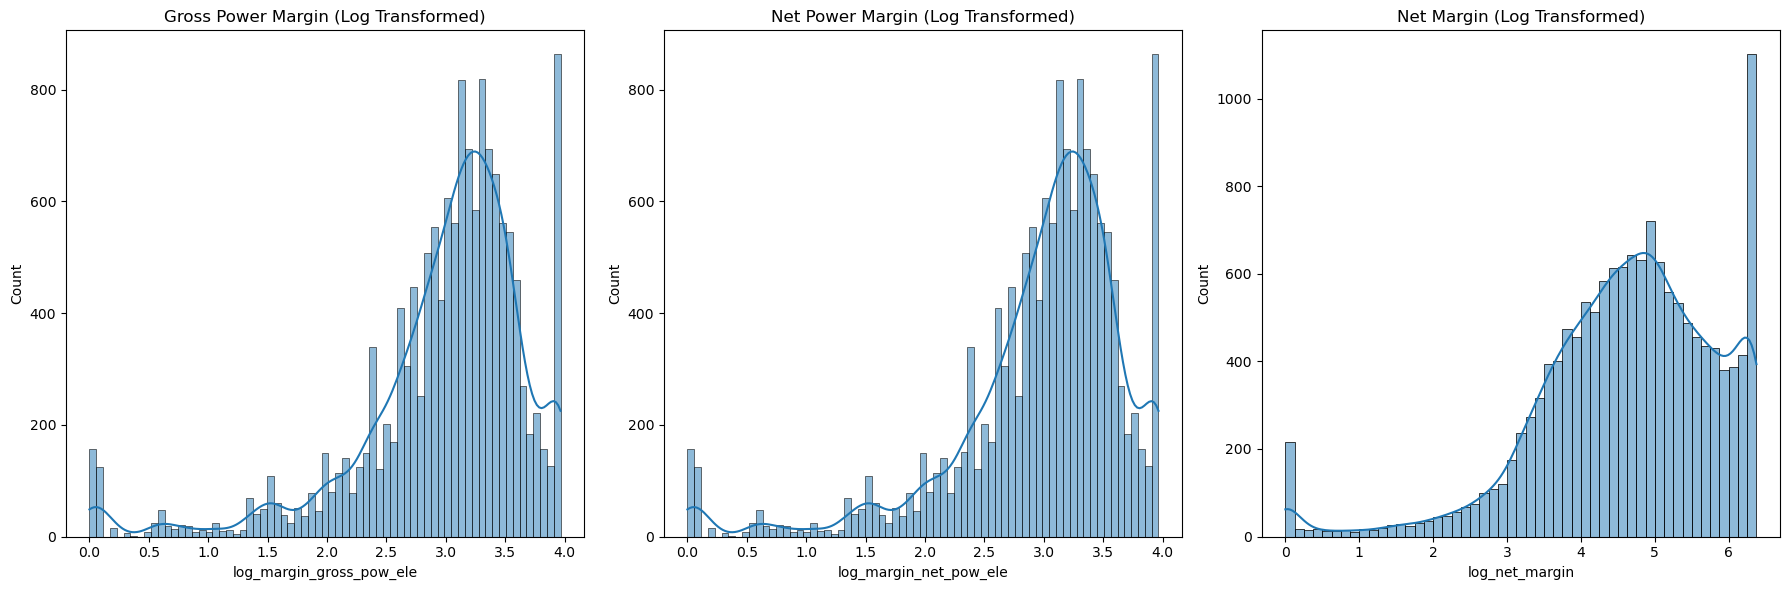

In [31]:
# Visualize the log-transformed data
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(agg_df['log_margin_gross_pow_ele'], kde=True, ax=axes[0])
axes[0].set_title('Gross Power Margin (Log Transformed)')

sns.histplot(agg_df['log_margin_net_pow_ele'], kde=True, ax=axes[1])
axes[1].set_title('Net Power Margin (Log Transformed)')

sns.histplot(agg_df['log_net_margin'], kde=True, ax=axes[2])
axes[2].set_title('Net Margin (Log Transformed)')

plt.tight_layout()
plt.show()

The logarithmic transformation has effectively condensed the data, making it easier to analyze and reducing the impact of extreme values. The distribution Gross Power Margin (Log transformed) appears to be somewhat normally distributed with a peak around 3.0.Similar to the gross power margin, the net power margin also shows a somewhat normal distribution with a peak around 3.0.The net margin has a different distribution compared to the other two margins. It has a peak around 4.0 and shows a more pronounced right skew. The log transformation has helped in reducing the extreme skewness observed in the original net margin distribution.

In [32]:
# Move to other columns and transform data

skewed = [
    'cons_12m', 
    'cons_gas_12m',
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_meter_rent_12m', 
    'imp_cons'
    
]

In [43]:
# Identify the threshold for capping (95th percentile)

cap_threshold_cons_12m = agg_df['cons_12m'].quantile(0.95)
cap_threshold_cons_gas_12m = agg_df['cons_gas_12m'].quantile(0.95)
cap_threshold_cons_last_month = agg_df['cons_last_month'].quantile(0.95)
cap_threshold_forecast_cons_12m = agg_df['forecast_cons_12m'].quantile(0.95)
cap_threshold_forecast_cons_year = agg_df['forecast_cons_year'].quantile(0.95)
cap_threshold_forecast_meter_rent_12m = agg_df['forecast_meter_rent_12m'].quantile(0.95)
cap_threshold_imp_cons = agg_df['imp_cons'].quantile(0.95)

In [44]:
# Cap the outliers
agg_df['cons_12m_capped'] = np.where(agg_df['cons_12m'] > cap_threshold_cons_12m, cap_threshold_cons_12m, agg_df['cons_12m'])
agg_df['cons_gas_12m_capped'] = np.where(agg_df['cons_gas_12m'] > cap_threshold_cons_gas_12m, cap_threshold_cons_gas_12m, agg_df['cons_gas_12m'])
agg_df['cons_last_month_capped'] = np.where(agg_df['cons_last_month'] > cap_threshold_cons_last_month, cap_threshold_cons_last_month, agg_df['cons_gas_12m'])
agg_df['forecast_cons_12m_capped'] = np.where(agg_df['forecast_cons_12m'] > cap_threshold_forecast_cons_12m, cap_threshold_forecast_cons_12m, agg_df['forecast_cons_12m'])
agg_df['forecast_cons_year_capped'] = np.where(agg_df['forecast_cons_year'] > cap_threshold_forecast_cons_year, cap_threshold_forecast_cons_year, agg_df['forecast_cons_year'])
agg_df['forecast_meter_rent_12m_capped'] = np.where(agg_df['forecast_meter_rent_12m'] > cap_threshold_forecast_meter_rent_12m, cap_threshold_forecast_meter_rent_12m, agg_df['forecast_meter_rent_12m'])
agg_df['imp_cons_capped'] = np.where(agg_df['imp_cons'] > cap_threshold_imp_cons, cap_threshold_imp_cons, agg_df['imp_cons'])

In [45]:
# Use log10 to compress data

agg_df['log_cons_12m'] = np.log10(agg_df['cons_12m_capped'] +1)
agg_df['log_cons_last_month'] = np.log10(agg_df['cons_last_month_capped'] +1)
agg_df['log_forecast_cons_12m'] = np.log10(agg_df['forecast_cons_12m_capped']+1)
agg_df['log_cons_gas_12m'] = np.log10(agg_df['cons_gas_12m_capped']+1)
agg_df['log_forecast_cons_year'] = np.log10(agg_df['forecast_cons_year_capped']+1)
agg_df['log_forecast_meter_rent_12m'] = np.log10(agg_df['forecast_meter_rent_12m_capped']+1)
agg_df['log_imp_cons'] = np.log10(agg_df['imp_cons_capped']+1)


In [46]:
agg_df[['log_cons_12m', 'log_cons_last_month', 'log_forecast_cons_12m', 'log_cons_gas_12m', 'log_forecast_cons_year', 'log_forecast_meter_rent_12m',
       'log_imp_cons']].describe()

,log_cons_12m,log_cons_last_month,log_forecast_cons_12m,log_cons_gas_12m,log_forecast_cons_year,log_forecast_meter_rent_12m,log_imp_cons
count,14523.000000,14523.000000,14523.000000,14523.000000,14523.000000,14523.000000,14523.000000
mean,4.208233,0.890043,2.955953,0.746810,1.776102,1.512371,1.232012
std,0.846363,1.794653,0.673285,1.629708,1.572309,0.562935,1.124132
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.754081,0.000000,2.695114,0.000000,0.000000,1.235023,0.000000
50%,4.149804,0.000000,3.046507,0.000000,2.498311,1.296665,1.584218
75%,4.610335,0.000000,3.380241,0.000000,3.241546,2.120673,2.289823
max,5.962233,6.618528,3.787063,4.882337,3.775451,2.166454,2.805523


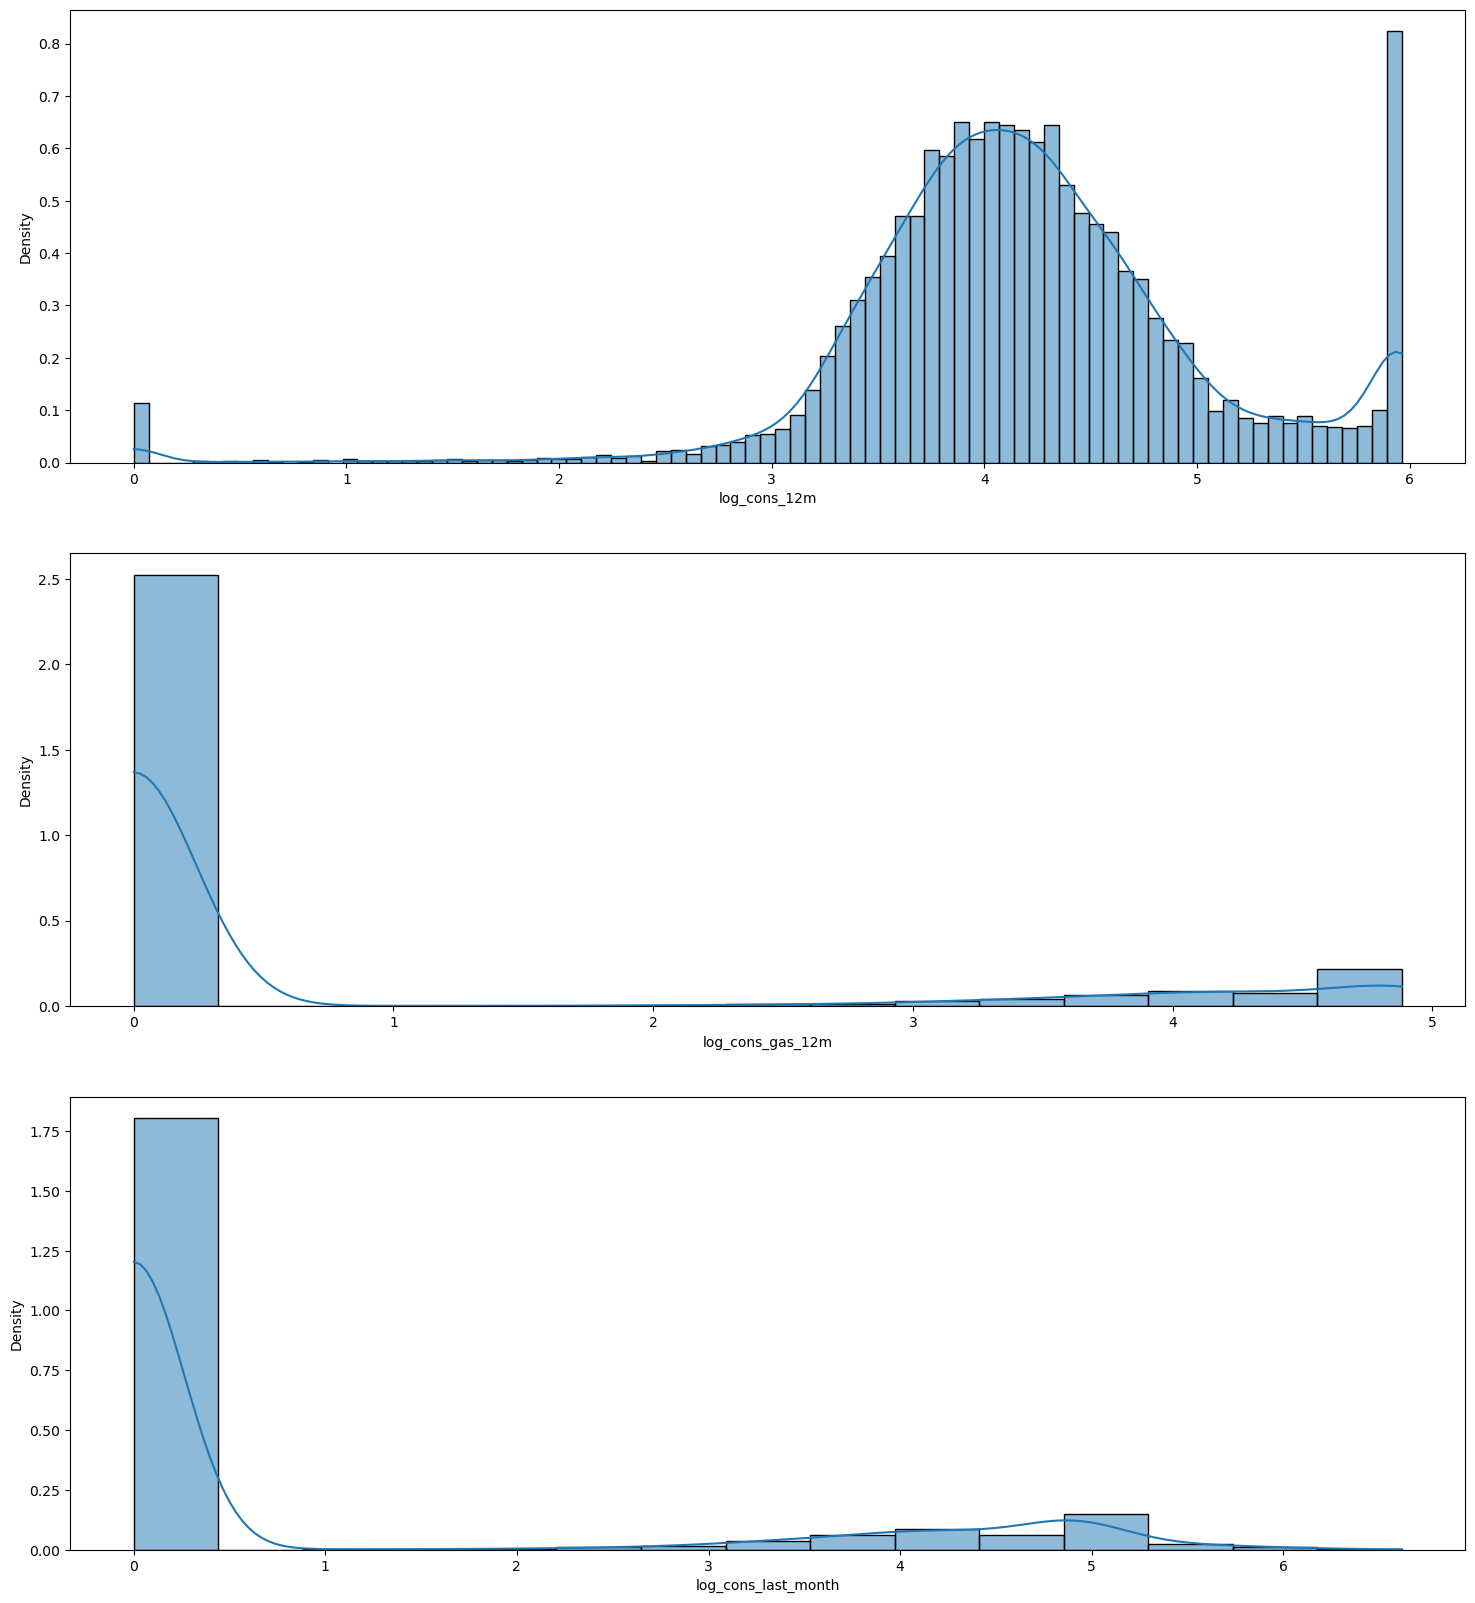

In [71]:
# Data log visualisation_1

fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
sns.histplot(agg_df["log_cons_12m"], kde=True,stat="density", ax=axs[0])
sns.histplot(agg_df["log_cons_gas_12m"], kde=True, stat="density", ax=axs[1])
sns.histplot(agg_df["log_cons_last_month"], kde=True, stat="density", ax=axs[2])
plt.show()

The distribution of Annual Electricity Consumption appears to be relatively normal with a slight right skew, centered around 4.0.The small spike at the left end near zero suggests that there are customers with minimal or no electricity consumption.The distribution of Annual Gas Consumption is highly right-skewed, with a large number of customers having very low gas consumption (spike at zero). There are still a few customers with high gas consumption, but the majority of the data points are concentrated near zero. The distribution of Last Month’s Consumption is highly right-skewed, with a significant spike at zero, indicating that a large number of customers have minimal or no consumption for the last month.

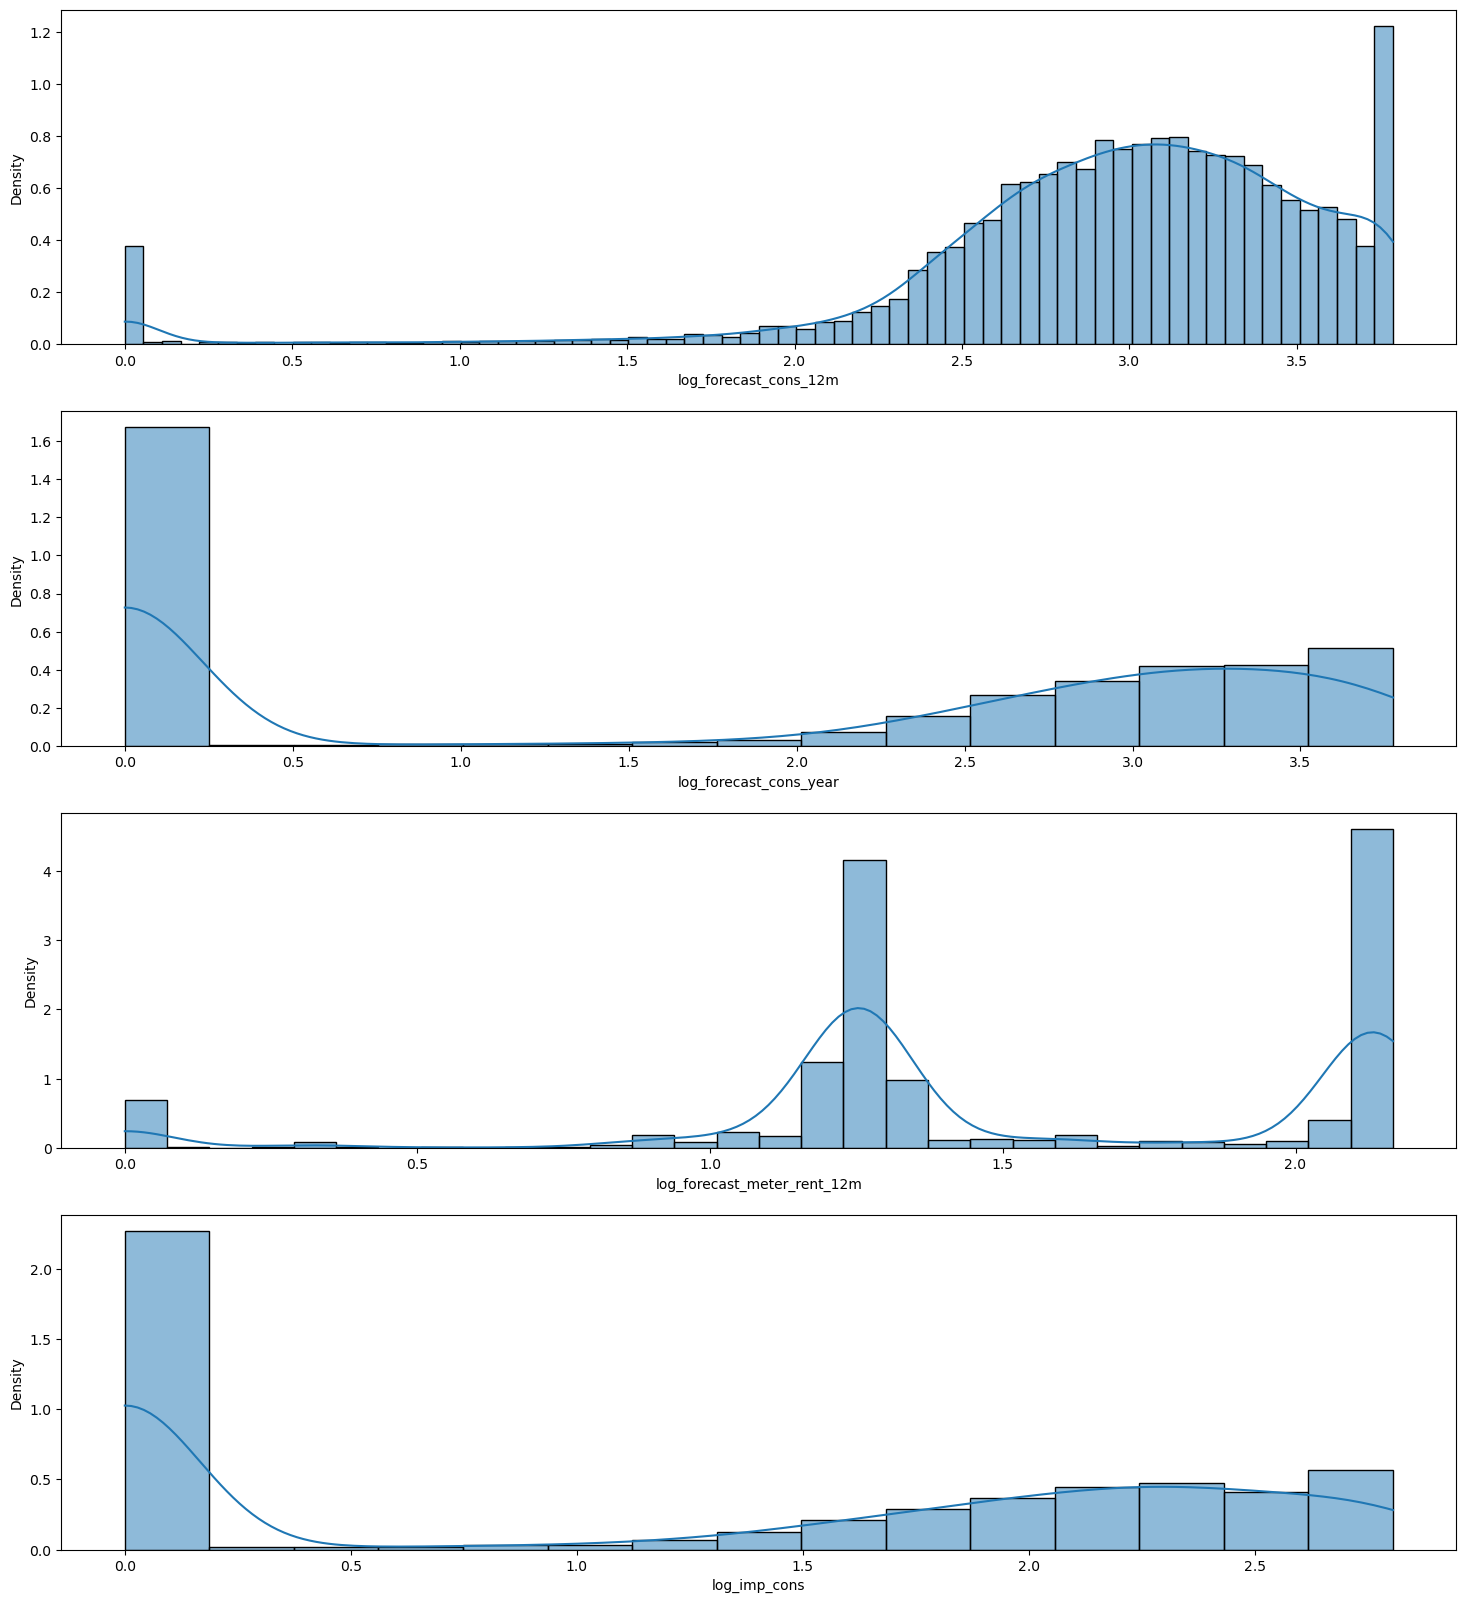

In [72]:
# Data log visualisation_2

fig, axs = plt.subplots(nrows=4, figsize=(18, 20))
sns.histplot(agg_df["log_forecast_cons_12m"], kde=True,stat="density", ax=axs[0])
sns.histplot(agg_df["log_forecast_cons_year"], kde=True, stat="density", ax=axs[1])
sns.histplot(agg_df["log_forecast_meter_rent_12m"], kde=True, stat="density", ax=axs[2])
sns.histplot(agg_df["log_imp_cons"], kde=True, stat="density", ax=axs[3])
plt.show()

The distribution of Forecasted Annual Consumption shows a significant spike at zero, indicating that a large number of customers have minimal or no forecasted annual consumption. Beyond the initial spike, the distribution becomes more uniform with a slight right skew, peaking around 3.0 and tapering off toward 3.5. The majority of the Forecasted Consumption for the Next Year are concentrated near zero, indicating many customers have minimal or no forecasted consumption for the next year. The distribution of Forecasted Meter Rent for 12 Months has a significant spike at zero, indicating that many customers have minimal or no forecasted meter rent for the next 12 months. The small peak at the far right end (around 2.0) indicates that a few customers have higher forecasted meter rent.

### Customers segmentation based on cons_12m

In [79]:
# Define custom segments based on cons_12m thresholds

def segment_consumption(consumption):
    if consumption < 20000:
        return 'Low'
    elif 20000 <= consumption < 100000:
        return 'Medium'
    elif 100000 <= consumption < 1000000:
        return 'High'
    else:
        return 'Very High'

agg_df['cons_12m_segment'] = agg_df['cons_12m'].apply(segment_consumption)
agg_df[['cons_12m', 'cons_12m_segment']].head()

,cons_12m,cons_12m_segment
0,0,Low
1,4660,Low
2,544,Low
3,1584,Low
4,4425,Low


In [105]:
agg_df['cons_12m_segment'].value_counts()

Low          8624
Medium       3926
High         1325
Very High     648
Name: cons_12m_segment, dtype: int64

We can see that the most of clients have low and medium annual electricity consumptions

In [83]:
pd.options.display.max_columns = None 
display(agg_df)

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max,var_year_price_off_peak_var,var_year_price_peak_var,var_year_price_mid_peak_var,var_year_price_off_peak_fix,var_year_price_peak_fix,var_year_price_mid_peak_fix,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal,f,t,channel_sales_Channel 1,channel_sales_Channel 2,channel_sales_Channel 3,channel_sales_Channel 4,channel_sales_Channel 5,origin_up_Category 1,origin_up_Category 2,origin_up_Category 3,margin_gross_pow_ele_capped,margin_net_pow_ele_capped,net_margin_capped,log_margin_gross_pow_ele,log_margin_net_pow_ele,log_net_margin,cons_12m_capped,cons_gas_12m_capped,cons_last_month_capped,forecast_cons_12m_capped,forecast_cons_year_capped,forecast_meter_rent_12m_capped,imp_cons_capped,log_cons_12m,log_cons_gas_12m,log_cons_last_month,log_forecast_cons_12m,log_forecast_cons_year,log_forecast_meter_rent_12m,log_imp_cons,cons_12m_segment
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0.0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,43.648,0.000061,2.627605e-05,4.402763e-04,1.102785e+00,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.266930,30,5,2,6,0,1,1,0,0,0,0,1,0,0,25.44,25.44,587.377,3.274878,3.274878,6.377368,0.0,54946.0,54946.0,0.00,0.0,1.78,0.00,0.000000,4.739944,4.739944,0.000000,0.000000,0.444045,0.000000,Low
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0.0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,13.800,0.000005,6.089453e-04,0.000000e+00,6.464779e-03,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.444710,76,7,76,4,1,0,0,1,0,0,0,0,1,0,16.38,16.38,18.890,2.855320,2.855320,2.990217,4660.0,0.0,0.0,189.95,0.0,16.27,0.00,3.668479,0.000000,0.000000,2.280920,0.000000,1.237292,0.000000,Low
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0.0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,13.856,0.000006,2.558511e-07,0.000000e+00,7.661891e-03,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.444710,68,3,68,8,1,0,1,0,0,0,0,0,1,0,28.60,28.60,6.600,3.387774,3.387774,2.028148,544.0,0.0,0.0,47.96,0.0,38.72,0.00,2.736397,0.000000,0.000000,1.689841,0.000000,1.599009,0.000000,Low
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0.0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,13.200,0.000005,0.000000e+00,0.000000e+00,6.464721e-03,0.000

In [84]:
# Columns names

agg_df.columns.values

array(['id', 'cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_cons_year',
       'forecast_discount_energy', 'forecast_meter_rent_12m',
       'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
       'forecast_price_pow_off_peak', 'has_gas', 'imp_cons',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin', 'num_years_antig', 'pow_max',
       'var_year_price_off_peak_var', 'var_year_price_peak_var',
       'var_year_price_mid_peak_var', 'var_year_price_off_peak_fix',
       'var_year_price_peak_fix', 'var_year_price_mid_peak_fix',
       'var_year_price_off_peak', 'var_year_price_peak',
       'var_year_price_mid_peak', 'var_6m_price_off_peak_var',
       'var_6m_price_peak_var', 'var_6m_price_mid_peak_var',
       'var_6m_price_off_peak_fix', 'var_6m_price_peak_fix',
       'var_6m_price_mid_peak_fix', 'var_6m_price_off_peak',
       'var_6m_price_peak', 'var_6m_price_mid_peak', 'churn',
       'offpe

In [87]:
# Drop extra columns

agg_df_new = agg_df.drop(columns=['cons_12m', 'cons_gas_12m', 'cons_last_month',
       'forecast_cons_12m', 'forecast_cons_year',
       'forecast_discount_energy', 'forecast_meter_rent_12m',
       'forecast_price_energy_off_peak', 'forecast_price_energy_peak',
       'forecast_price_pow_off_peak', 'has_gas', 'imp_cons',
       'margin_gross_pow_ele', 'margin_net_pow_ele', 'nb_prod_act',
       'net_margin','var_year_price_off_peak_var', 'var_year_price_peak_var',
       'var_year_price_mid_peak_var', 'var_6m_price_off_peak_var',
       'var_6m_price_peak_var', 'var_6m_price_mid_peak_var', 'num_years_antig', 'margin_gross_pow_ele_capped', 'margin_net_pow_ele_capped',
       'net_margin_capped', 'cons_12m_capped',
       'cons_gas_12m_capped', 'cons_last_month_capped',
       'forecast_cons_12m_capped', 'forecast_cons_year_capped',
       'forecast_meter_rent_12m_capped', 'imp_cons_capped' ])
agg_df_new.head()

,id,pow_max,var_year_price_off_peak_fix,var_year_price_peak_fix,var_year_price_mid_peak_fix,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,months_activ,months_to_end,months_modif_prod,months_renewal,f,t,channel_sales_Channel 1,channel_sales_Channel 2,channel_sales_Channel 3,channel_sales_Channel 4,channel_sales_Channel 5,origin_up_Category 1,origin_up_Category 2,origin_up_Category 3,log_margin_gross_pow_ele,log_margin_net_pow_ele,log_net_margin,log_cons_12m,log_cons_gas_12m,log_cons_last_month,log_forecast_cons_12m,log_forecast_cons_year,log_forecast_meter_rent_12m,log_imp_cons,cons_12m_segment
0,24011ae4ebbe3035111d65fa7c15bc57,43.648,1.102785,49.550703,22.022535,1.102846,4.955073e+01,22.022975,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693,30,5,2,6,0,1,1,0,0,0,0,1,0,0,3.274878,3.274878,6.377368,0.000000,4.739944,4.739944,0.000000,0.000000,0.444045,0.00000,Low
1,d29c2c54acc38ff3c0614d0a653813dd,13.800,0.006465,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471,76,7,76,4,1,0,0,1,0,0,0,0,1,0,2.855320,2.855320,2.990217,3.668479,0.000000,0.000000,2.280920,0.000000,1.237292,0.00000,Low
2,764c75f661154dac3a6c254cd082ea7d,13.856,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471,68,3,68,8,1,0,1,0,0,0,0,0,1,0,3.387774,3.387774,2.028148,2.736397,0.000000,0.000000,1.689841,0.000000,1.599009,0.00000,Low
3,bba03439a292a1e166f80264c16191cb,13.200,0.006465,0.000000,0.000000,0.006470,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471,69,2,69,9,1,0,0,0,1,0,0,0,1,0,3.441059,3.441059,3.275634,3.200029,0.000000,0.000000,2.382089,0.000000,1.318689,0.00000,Low
4,149d57cf92fc41cf94415803a877cb4b,19.800,0.005429,0.001954,0.000869,0.005444,1.957971e-03,0.000871,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733,71,2,71,9,1,0,0,1,0,0,0,0,1,0,3.826683,3.826683,3.891412,3.646011,0.000000,0.000000,2.650065,2.721811,2.122969,1.72689,Low


In [88]:
# Rename some columns

columns_names = ['id', 'pow_max',
       'var_year_price_off_peak_fix',
       'var_year_price_peak_fix', 'var_year_price_mid_peak_fix',
       'var_year_price_off_peak', 'var_year_price_peak',
       'var_year_price_mid_peak',
       'var_6m_price_off_peak_fix', 'var_6m_price_peak_fix',
       'var_6m_price_mid_peak_fix', 'var_6m_price_off_peak',
       'var_6m_price_peak', 'var_6m_price_mid_peak', 'churn',
       'dec_january_offpeak_diff_energy',
       'dec_january_offpeak_diff_power', 'mean_diff_off_peak_peak_var',
       'mean_diff_peak_mid_peak_var', 'mean_diff_off_peak_mid_peak_var',
       'mean_diff_off_peak_peak_fix', 'mean_diff_peak_mid_peak_fix',
       'mean_diff_off_peak_mid_peak_fix',
       'monthly_diff_off_peak_peak_var_max',
       'monthly_diff_peak_mid_peak_var_max',
       'monthly_diff_off_peak_mid_peak_var_max',
       'monthly_diff_off_peak_peak_fix_max',
       'monthly_diff_peak_mid_peak_fix_max',
       'monthly_diff_off_peak_mid_peak_fix', 'months_activ',
       'months_to_end', 'months_modif_prod', 'months_renewal', 'gas', 'no_gas',
       'Sales_Channel 1', 'Sales_Channel 2',
       'Sales_Channel 3', 'Sales_Channel 4',
       'Sales_Channel 5', 'Category 1',
       'Category 2', 'Category 3', 'log_margin_gross_pow_ele',
       'log_margin_net_pow_ele', 'log_net_margin', 
       'log_cons_12m', 'log_cons_gas_12m', 'log_cons_last_month',
       'log_forecast_cons_12m', 'log_forecast_cons_year',
       'log_forecast_meter_rent_12m', 'log_imp_cons', 'cons_12m_segment']

In [89]:
agg_df_new.columns = columns_names
agg_df_new.head()

,id,pow_max,var_year_price_off_peak_fix,var_year_price_peak_fix,var_year_price_mid_peak_fix,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,dec_january_offpeak_diff_energy,dec_january_offpeak_diff_power,mean_diff_off_peak_peak_var,mean_diff_peak_mid_peak_var,mean_diff_off_peak_mid_peak_var,mean_diff_off_peak_peak_fix,mean_diff_peak_mid_peak_fix,mean_diff_off_peak_mid_peak_fix,monthly_diff_off_peak_peak_var_max,monthly_diff_peak_mid_peak_var_max,monthly_diff_off_peak_mid_peak_var_max,monthly_diff_off_peak_peak_fix_max,monthly_diff_peak_mid_peak_fix_max,monthly_diff_off_peak_mid_peak_fix,months_activ,months_to_end,months_modif_prod,months_renewal,gas,no_gas,Sales_Channel 1,Sales_Channel 2,Sales_Channel 3,Sales_Channel 4,Sales_Channel 5,Category 1,Category 2,Category 3,log_margin_gross_pow_ele,log_margin_net_pow_ele,log_net_margin,log_cons_12m,log_cons_gas_12m,log_cons_last_month,log_forecast_cons_12m,log_forecast_cons_year,log_forecast_meter_rent_12m,log_imp_cons,cons_12m_segment
0,24011ae4ebbe3035111d65fa7c15bc57,43.648,1.102785,49.550703,22.022535,1.102846,4.955073e+01,22.022975,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693,30,5,2,6,0,1,1,0,0,0,0,1,0,0,3.274878,3.274878,6.377368,0.000000,4.739944,4.739944,0.000000,0.000000,0.444045,0.00000,Low
1,d29c2c54acc38ff3c0614d0a653813dd,13.800,0.006465,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471,76,7,76,4,1,0,0,1,0,0,0,0,1,0,2.855320,2.855320,2.990217,3.668479,0.000000,0.000000,2.280920,0.000000,1.237292,0.00000,Low
2,764c75f661154dac3a6c254cd082ea7d,13.856,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471,68,3,68,8,1,0,1,0,0,0,0,0,1,0,3.387774,3.387774,2.028148,2.736397,0.000000,0.000000,1.689841,0.000000,1.599009,0.00000,Low
3,bba03439a292a1e166f80264c16191cb,13.200,0.006465,0.000000,0.000000,0.006470,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471,69,2,69,9,1,0,0,0,1,0,0,0,1,0,3.441059,3.441059,3.275634,3.200029,0.000000,0.000000,2.382089,0.000000,1.318689,0.00000,Low
4,149d57cf92fc41cf94415803a877cb4b,19.800,0.005429,0.001954,0.000869,0.005444,1.957971e-03,0.000871,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775,24.43733,71,2,71,9,1,0,0,1,0,0,0,0,1,0,3.826683,3.826683,3.891412,3.646011,0.000000,0.000000,2.650065,2.721811,2.122969,1.72689,Low


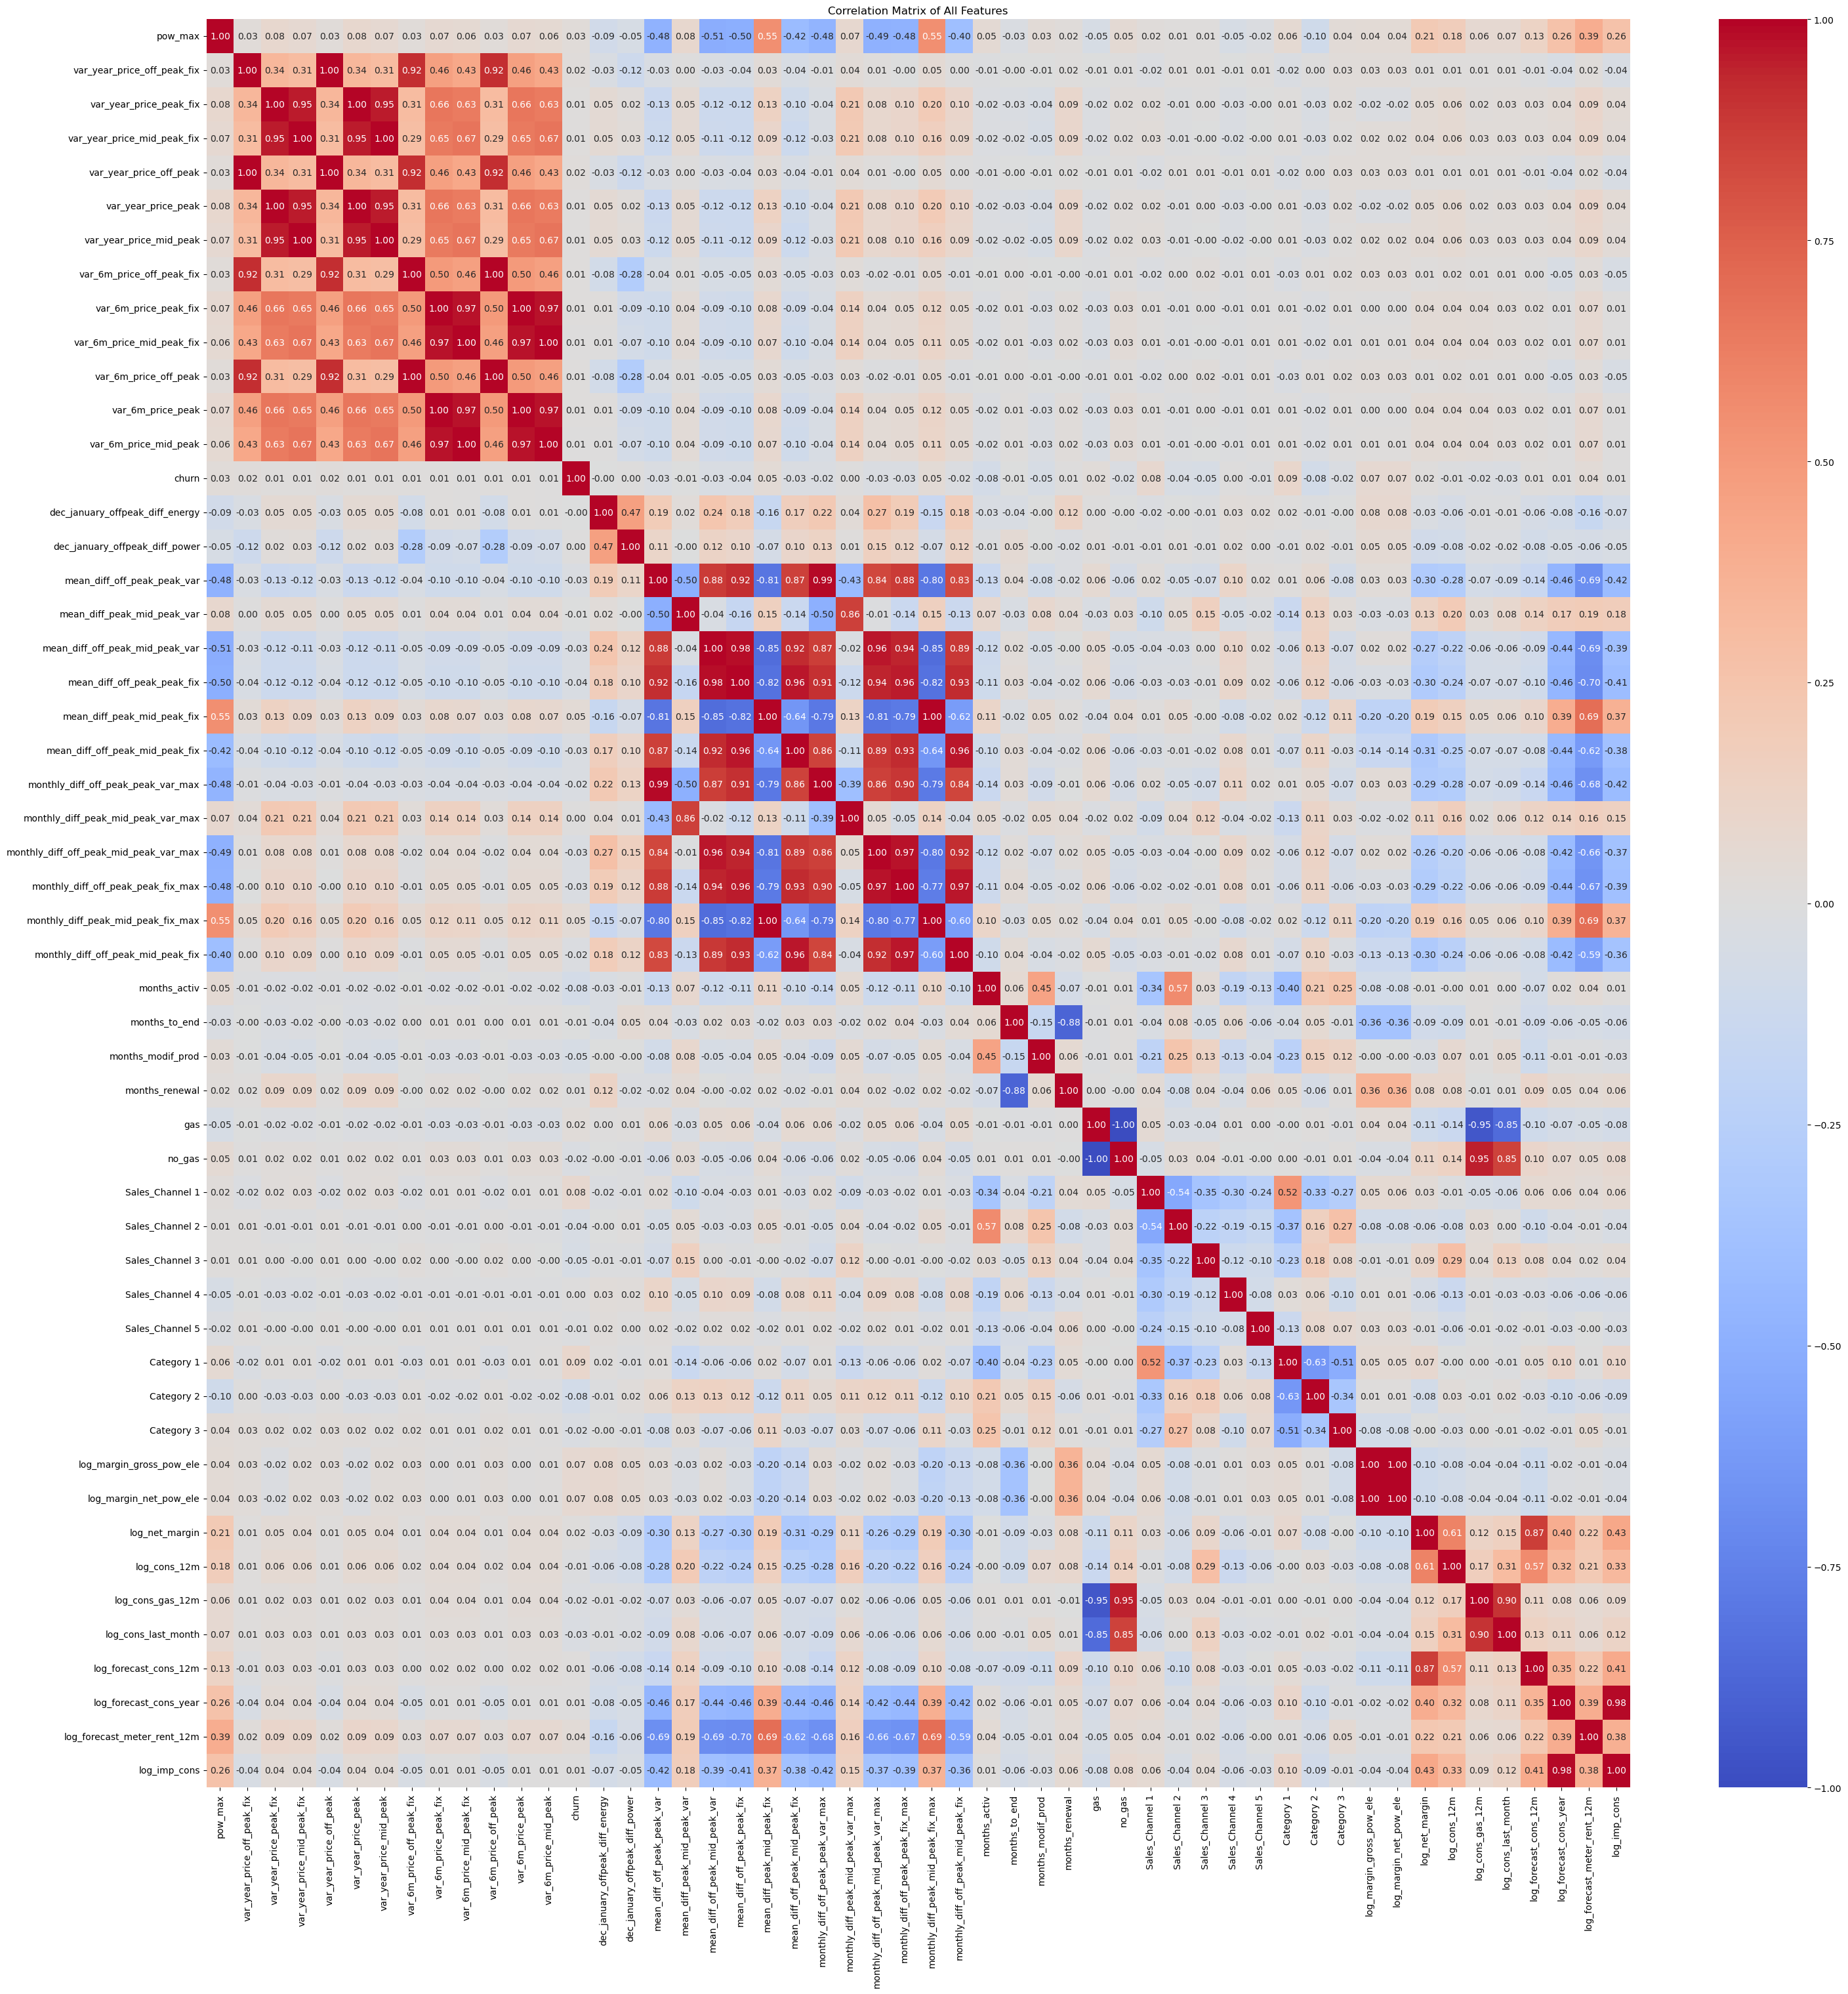

In [91]:
# Compute the correlation matrix
corr_matrix = agg_df_new.corr()

# Plot the heatmap
plt.figure(figsize=(35, 35))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of All Features')
plt.show()

In [101]:
# Try to make our data a bit clear and identify highly correlated features and weakly correlated features with the target variable.

# Thresholds for correlation
high_corr_threshold = 0.90
low_corr_threshold = 0.01

corr_matrix = agg_df_new.corr().abs()

# Identify highly correlated features
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop_high = [column for column in upper.columns if any(upper[column] > high_corr_threshold)]

# Identify weakly correlated features with churn
to_drop_low = [column for column in corr_matrix.columns if abs(corr_matrix[column]['churn']) < low_corr_threshold]

# Combine lists and drop features
to_drop = list(set(to_drop_high + to_drop_low))
agg_df_reduced = agg_df_new.drop(columns=to_drop)

agg_df_reduced.head()


,id,pow_max,var_year_price_off_peak_fix,var_year_price_peak_fix,var_6m_price_peak_fix,churn,mean_diff_off_peak_peak_var,mean_diff_off_peak_mid_peak_var,mean_diff_peak_mid_peak_fix,months_activ,months_modif_prod,gas,Sales_Channel 1,Sales_Channel 2,Sales_Channel 3,Sales_Channel 5,Category 1,Category 2,Category 3,log_margin_gross_pow_ele,log_net_margin,log_cons_12m,log_forecast_cons_12m,log_forecast_meter_rent_12m,cons_12m_segment
0,24011ae4ebbe3035111d65fa7c15bc57,43.648,1.102785,49.550703,99.530517,1,0.024038,0.058257,7.450670,30,2,0,1,0,0,0,1,0,0,3.274878,6.377368,0.000000,0.000000,0.444045,Low
1,d29c2c54acc38ff3c0614d0a653813dd,13.800,0.006465,0.000000,0.000000,0,0.142485,0.149609,0.000000,76,76,1,0,1,0,0,0,1,0,2.855320,2.990217,3.668479,2.280920,1.237292,Low
2,764c75f661154dac3a6c254cd082ea7d,13.856,0.007662,0.000000,0.000000,0,0.082090,0.170512,0.000000,68,68,1,1,0,0,0,0,1,0,3.387774,2.028148,2.736397,1.689841,1.599009,Low
3,bba03439a292a1e166f80264c16191cb,13.200,0.006465,0.000000,0.000000,0,0.151210,0.151210,0.000000,69,69,1,0,0,1,0,0,1,0,3.441059,3.275634,3.200029,2.382089,1.318689,Low
4,149d57cf92fc41cf94415803a877cb4b,19.800,0.005429,0.001954,0.000000,0,0.020536,0.051309,8.137629,71,71,1,0,1,0,0,0,1,0,3.826683,3.891412,3.646011,2.650065,2.122969,Low


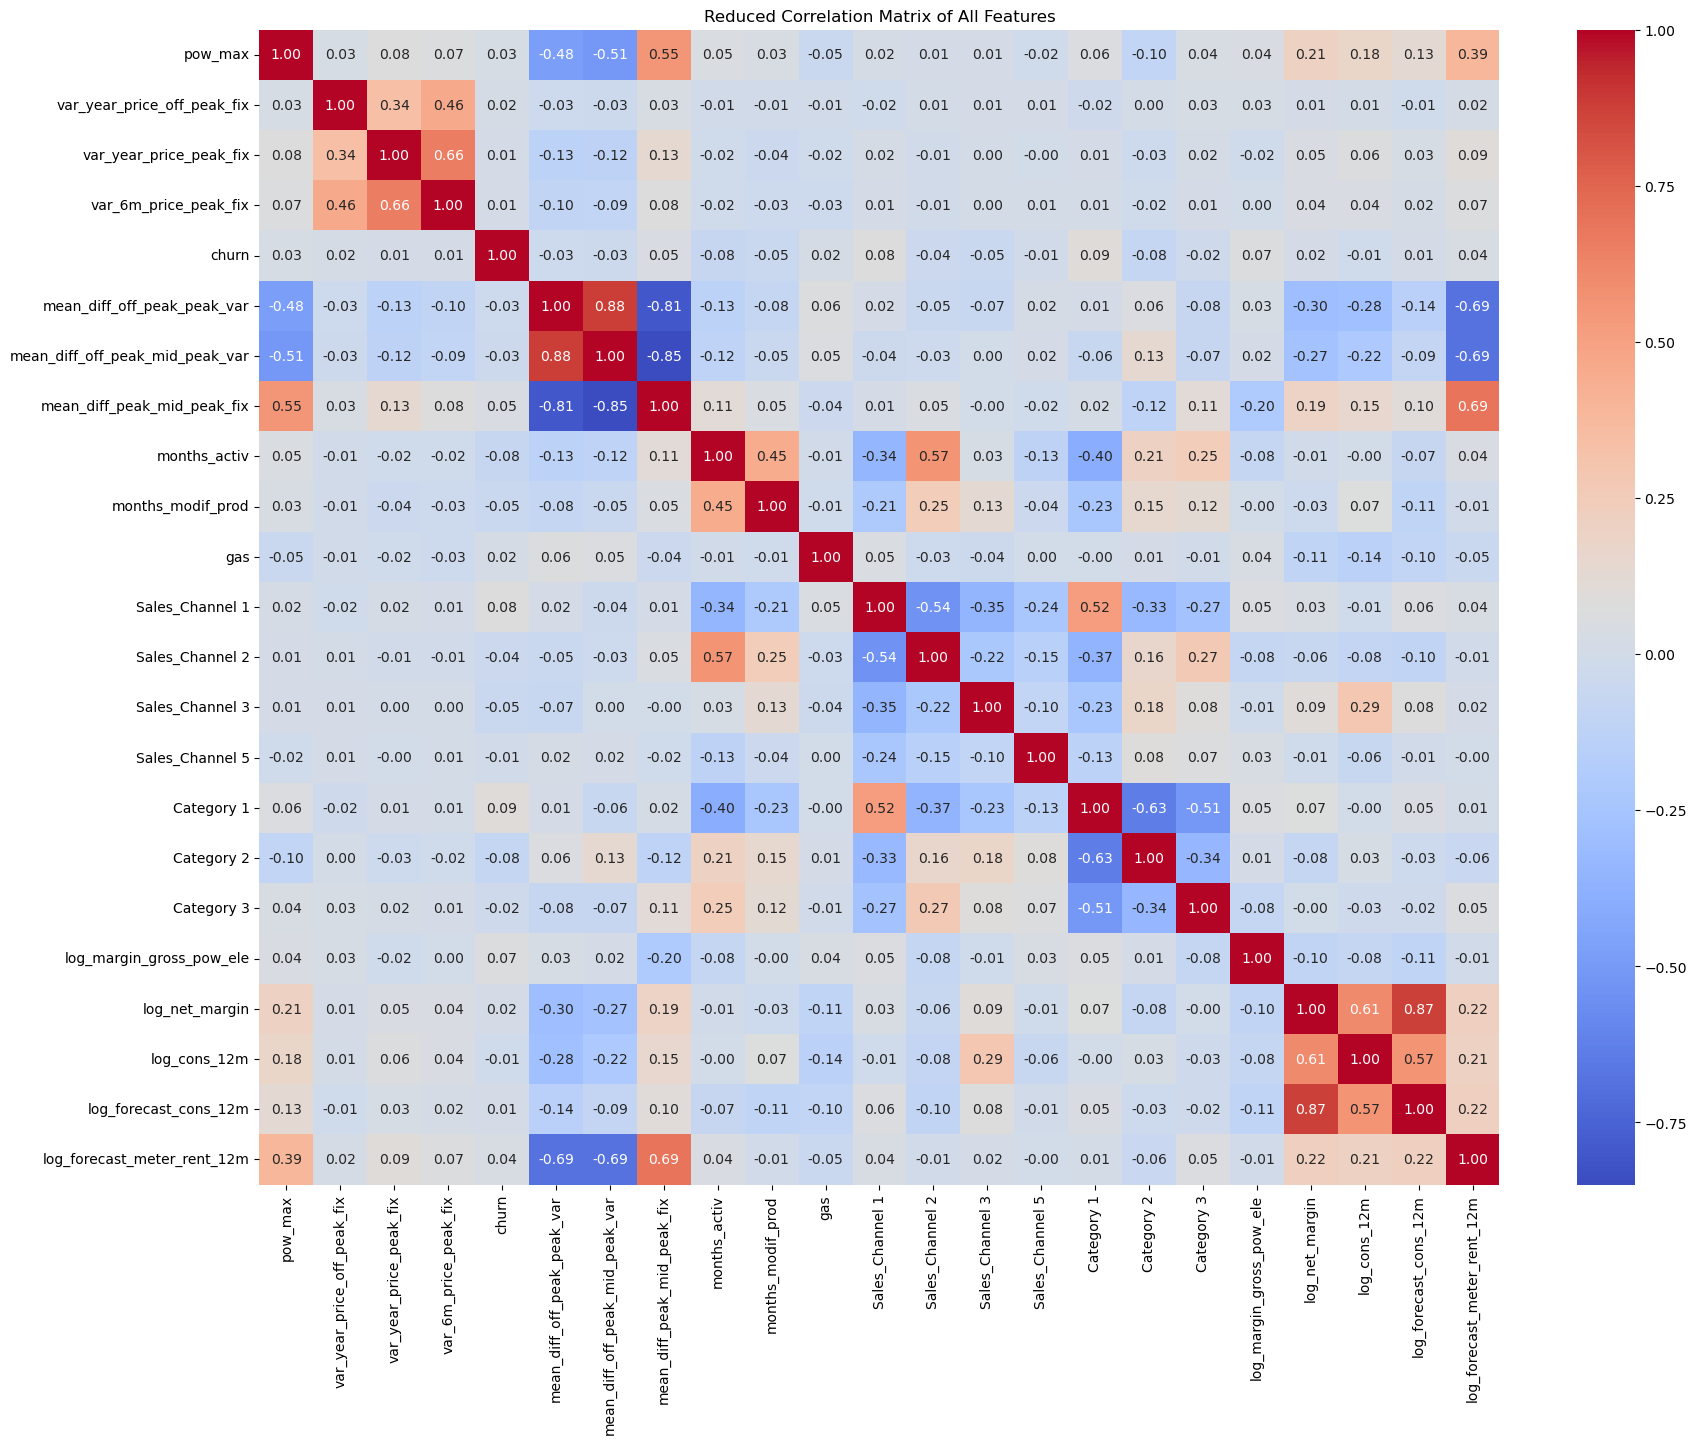

In [103]:
plt.figure(figsize=(20, 15))
sns.heatmap(agg_df_reduced.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Reduced Correlation Matrix of All Features')
plt.show()

It looks much better and we can move to predictive modeling.